In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime

In [2]:
window_size = 48
batch_size_exp = 1
epoch_exp = 7
neurons_exp = 50
predict_values_exp = 6000
lag_exp=72

In [3]:
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [4]:

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [5]:
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [6]:
def scale(data_norm):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(data_norm)
    # transform train
    data_norm = data_norm.reshape(data_norm.shape[0], data_norm.shape[1])
    data_scaled = scaler.transform(data_norm)
    return scaler, data_scaled


In [7]:
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [8]:
from keras.layers import Activation, Dense, BatchNormalization, TimeDistributed
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons_exp, dropout = 0.1 ,batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(BatchNormalization())
    model.add(Dense(50))
    model.add(Activation('relu'))
    model.add(Dense(50))
    model.add(Activation('tanh'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

In [9]:
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    #print(X)
    yhat = model.predict(X, batch_size=1)
    return yhat[0,0]


In [10]:
import pandas as pd
series = pd.read_csv('T1.csv',index_col="Date/Time")
series.head()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
Date/Time,,,,
01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
01 01 2018 00:30,419.645904,5.659674,516.127569,271.258087
01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [11]:
#del series['Air temperature | (\'C)']
del series['LV ActivePower (kW)']
del series['Wind Direction (°)']
del series['Theoretical_Power_Curve (KWh)']
series.head()

,Wind Speed (m/s)
Date/Time,
01 01 2018 00:00,5.311336
01 01 2018 00:10,5.672167
01 01 2018 00:20,5.216037
01 01 2018 00:30,5.659674
01 01 2018 00:40,5.577941


In [12]:
for i in range(0,10):
  series = series[:-1]
series.tail()

,Wind Speed (m/s)
Date/Time,
31 12 2018 21:30,8.472826
31 12 2018 21:40,8.433422
31 12 2018 21:50,9.976660
31 12 2018 22:00,10.416830
31 12 2018 22:10,10.713670


In [13]:
series.shape

(50520, 1)

In [14]:
raw_values = series.values
diff_values = difference(raw_values, 1)

In [15]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, lag_exp)
supervised_values = supervised.values
supervised_values

array([[0, 0, 0, ..., 0, 0, array([0.36083078])],
       [array([0.36083078]), 0, 0, ..., 0, 0, array([-0.45613003])],
       [array([-0.45613003]), array([0.36083078]), 0, ..., 0, 0,
        array([0.44363737])],
       ...,
       [array([-0.03940391]), array([-1.16279221]), array([1.13698769]),
        ..., array([1.36798096]), array([0.23359704]),
        array([1.54323769])],
       [array([1.54323769]), array([-0.03940391]), array([-1.16279221]),
        ..., array([0.41610289]), array([1.36798096]),
        array([0.44017029])],
       [array([0.44017029]), array([1.54323769]), array([-0.03940391]),
        ..., array([-0.62018394]), array([0.41610289]),
        array([0.29683972])]], dtype=object)

In [16]:
# split data into train and test-sets
scaler,supervised_values = scale(supervised_values)
train_scaled, test_scaled = supervised_values[0:-predict_values_exp], supervised_values[-predict_values_exp:]
#print(test_scaled)

In [19]:
len(train_scaled), len(test_scaled)

(44519, 6000)

In [17]:
lstm_model = fit_lstm(train_scaled, batch_size_exp, epoch_exp, neurons_exp)


44519/44519 [==============================] - 132s 3ms/step - loss: 0.0018


In [22]:
# # walk-forward validation on the test data
# predictions = list()
# expectations = list()
# for i in range(len(test_scaled)-window_size):
#     window_prediction_frame = test_scaled
#     test_pred = list()
#     for j in range(window_size):
#         X, y = window_prediction_frame[i, 0:-1], window_prediction_frame[i, -1]
#         yhat = forecast_lstm(lstm_model, 1, X)#batch_size_exp to 1
#         # Replacing value in test scaled with the predicted value.
#         test_pred = [yhat] + test_pred 
#         if len(test_pred) > lag_exp+1:
#             test_pred = test_pred[:-1]
#         if j+1<len(window_prediction_frame):
#             if j+1 > lag_exp+1:
#                 window_prediction_frame[j+1] = test_pred
#             else:
#                 window_prediction_frame[j+1] = np.concatenate((test_pred, window_prediction_frame[j+1, j+1:]),axis=0)

#     # invert scaling
#     yhat = invert_scale(scaler, X, yhat)
#     # invert differencing
#     yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
#     # store forecast
#     expected = raw_values[len(train_scaled) + i + 1 + window_size]
#     predictions.append(yhat)
#     expectations.append(expected)
#     print('Hour=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
predictions = list()
expectations = list()
test_pred = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)#batch_size_exp to 1

    # Replacing value in test scaled with the predicted value.
    test_pred = [yhat] + test_pred 
    if len(test_pred) > lag_exp+1:
        test_pred = test_pred[:-1]
    if i+1<len(test_scaled):
        if i+1 > lag_exp+1:
            test_scaled[i+1] = test_pred
        else:
            test_scaled[i+1] = np.concatenate((test_pred, test_scaled[i+1, i+1:]),axis=0)

    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    expected = raw_values[len(train_scaled) + i + 1]
    if expected != 0:
        predictions.append(yhat)
        expectations.append(expected)
    print('Hour=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 27ms/step
Hour=1, Predicted=3.321924, Expected=5.472752
1/1 [==============================] - 0s 20ms/step
Hour=2, Predicted=4.621176, Expected=5.492820
1/1 [==============================] - 0s 19ms/step
Hour=3, Predicted=4.410503, Expected=5.112536
1/1 [==============================] - 0s 20ms/step
Hour=4, Predicted=3.964134, Expected=5.217622
1/1 [==============================] - 0s 20ms/step
Hour=5, Predicted=3.809265, Expected=5.417873
1/1 [==============================] - 0s 20ms/step
Hour=6, Predicted=4.137040, Expected=5.738088
1/1 [==============================] - 0s 21ms/step
Hour=7, Predicted=4.680907, Expected=5.456211
1/1 [==============================] - 0s 18ms/step
Hour=8, Predicted=4.784622, Expected=5.931525
1/1 [==============================] - 0s 22ms/step
Hour=9, Predicted=5.136049, Expected=4.800290
1/1 [==============================] - 0s 22ms/step
Hour=10, Predicted=3.989966, Expected=5.686024
1/1 [==============

Hour=83, Predicted=9.816690, Expected=9.407104
1/1 [==============================] - 0s 20ms/step
Hour=84, Predicted=9.271249, Expected=9.133518
1/1 [==============================] - 0s 21ms/step
Hour=85, Predicted=8.764576, Expected=9.217004
1/1 [==============================] - 0s 32ms/step
Hour=86, Predicted=8.621814, Expected=10.095000
1/1 [==============================] - 0s 21ms/step
Hour=87, Predicted=9.285217, Expected=10.672590
1/1 [==============================] - 0s 19ms/step
Hour=88, Predicted=9.867966, Expected=10.845640
1/1 [==============================] - 0s 20ms/step
Hour=89, Predicted=9.973621, Expected=10.639340
1/1 [==============================] - 0s 21ms/step
Hour=90, Predicted=9.781394, Expected=10.609780
1/1 [==============================] - 0s 21ms/step
Hour=91, Predicted=9.789528, Expected=10.693300
1/1 [==============================] - 0s 27ms/step
Hour=92, Predicted=9.934753, Expected=10.219140
1/1 [==============================] - 0s 22ms/step
Hou

1/1 [==============================] - 0s 22ms/step
Hour=165, Predicted=7.336720, Expected=6.922963
1/1 [==============================] - 0s 29ms/step
Hour=166, Predicted=7.252682, Expected=6.764936
1/1 [==============================] - 0s 18ms/step
Hour=167, Predicted=7.232304, Expected=6.271585
1/1 [==============================] - 0s 15ms/step
Hour=168, Predicted=6.870263, Expected=5.873626
1/1 [==============================] - 0s 19ms/step
Hour=169, Predicted=6.561395, Expected=5.948888
1/1 [==============================] - 0s 29ms/step
Hour=170, Predicted=6.716731, Expected=6.012838
1/1 [==============================] - 0s 21ms/step
Hour=171, Predicted=6.844186, Expected=5.434330
1/1 [==============================] - 0s 31ms/step
Hour=172, Predicted=6.238544, Expected=5.127420
1/1 [==============================] - 0s 19ms/step
Hour=173, Predicted=5.866074, Expected=4.489131
1/1 [==============================] - 0s 21ms/step
Hour=174, Predicted=5.146334, Expected=3.518667


1/1 [==============================] - 0s 22ms/step
Hour=247, Predicted=6.122408, Expected=7.177562
1/1 [==============================] - 0s 21ms/step
Hour=248, Predicted=6.123009, Expected=6.981458
1/1 [==============================] - 0s 20ms/step
Hour=249, Predicted=5.937905, Expected=6.919415
1/1 [==============================] - 0s 24ms/step
Hour=250, Predicted=5.979827, Expected=7.027781
1/1 [==============================] - 0s 26ms/step
Hour=251, Predicted=6.226623, Expected=6.897110
1/1 [==============================] - 0s 21ms/step
Hour=252, Predicted=6.252699, Expected=6.443200
1/1 [==============================] - 0s 26ms/step
Hour=253, Predicted=5.945837, Expected=5.895472
1/1 [==============================] - 0s 22ms/step
Hour=254, Predicted=5.572693, Expected=5.877490
1/1 [==============================] - 0s 20ms/step
Hour=255, Predicted=5.714094, Expected=6.355728
1/1 [==============================] - 0s 22ms/step
Hour=256, Predicted=6.320231, Expected=6.256725


1/1 [==============================] - 0s 26ms/step
Hour=329, Predicted=4.986072, Expected=5.993066
1/1 [==============================] - 0s 23ms/step
Hour=330, Predicted=5.107526, Expected=5.576375
1/1 [==============================] - 0s 25ms/step
Hour=331, Predicted=4.765305, Expected=5.544488
1/1 [==============================] - 0s 23ms/step
Hour=332, Predicted=4.711930, Expected=5.962460
1/1 [==============================] - 0s 30ms/step
Hour=333, Predicted=5.073323, Expected=6.471471
1/1 [==============================] - 0s 21ms/step
Hour=334, Predicted=5.497776, Expected=6.119368
1/1 [==============================] - 0s 20ms/step
Hour=335, Predicted=5.056280, Expected=6.948431
1/1 [==============================] - 0s 29ms/step
Hour=336, Predicted=5.826972, Expected=7.310340
1/1 [==============================] - 0s 16ms/step
Hour=337, Predicted=6.143873, Expected=8.373710
1/1 [==============================] - 0s 29ms/step
Hour=338, Predicted=7.188808, Expected=8.962428


1/1 [==============================] - 0s 19ms/step
Hour=410, Predicted=11.326016, Expected=11.663570
1/1 [==============================] - 0s 21ms/step
Hour=411, Predicted=11.063793, Expected=11.822810
1/1 [==============================] - 0s 21ms/step
Hour=412, Predicted=10.733022, Expected=11.966950
1/1 [==============================] - 0s 19ms/step
Hour=413, Predicted=10.629215, Expected=11.620560
1/1 [==============================] - 0s 19ms/step
Hour=414, Predicted=10.186434, Expected=10.858900
1/1 [==============================] - 0s 20ms/step
Hour=415, Predicted=9.432882, Expected=10.053450
1/1 [==============================] - 0s 20ms/step
Hour=416, Predicted=8.682159, Expected=11.546370
1/1 [==============================] - 0s 20ms/step
Hour=417, Predicted=10.191308, Expected=10.462400
1/1 [==============================] - 0s 21ms/step
Hour=418, Predicted=9.120624, Expected=10.318720
1/1 [==============================] - 0s 21ms/step
Hour=419, Predicted=9.005675, Exp

1/1 [==============================] - 0s 22ms/step
Hour=492, Predicted=7.395570, Expected=6.482977
1/1 [==============================] - 0s 22ms/step
Hour=493, Predicted=7.006448, Expected=6.196105
1/1 [==============================] - 0s 21ms/step
Hour=494, Predicted=6.964588, Expected=6.717604
1/1 [==============================] - 0s 21ms/step
Hour=495, Predicted=7.683257, Expected=6.689514
1/1 [==============================] - 0s 22ms/step
Hour=496, Predicted=7.753839, Expected=6.628686
1/1 [==============================] - 0s 29ms/step
Hour=497, Predicted=7.749010, Expected=7.045667
1/1 [==============================] - 0s 21ms/step
Hour=498, Predicted=8.189088, Expected=6.956045
1/1 [==============================] - 0s 22ms/step
Hour=499, Predicted=8.044550, Expected=7.575250
1/1 [==============================] - 0s 21ms/step
Hour=500, Predicted=8.591785, Expected=7.339194
1/1 [==============================] - 0s 21ms/step
Hour=501, Predicted=8.245333, Expected=7.971663


1/1 [==============================] - 0s 20ms/step
Hour=573, Predicted=7.532759, Expected=8.856277
1/1 [==============================] - 0s 21ms/step
Hour=574, Predicted=7.630860, Expected=8.853611
1/1 [==============================] - 0s 21ms/step
Hour=575, Predicted=7.656785, Expected=9.581532
1/1 [==============================] - 0s 20ms/step
Hour=576, Predicted=8.404979, Expected=9.592834
1/1 [==============================] - 0s 20ms/step
Hour=577, Predicted=8.535352, Expected=11.025680
1/1 [==============================] - 0s 19ms/step
Hour=578, Predicted=10.127289, Expected=9.147723
1/1 [==============================] - 0s 20ms/step
Hour=579, Predicted=8.405592, Expected=8.551741
1/1 [==============================] - 0s 31ms/step
Hour=580, Predicted=7.955946, Expected=7.233285
1/1 [==============================] - 0s 19ms/step
Hour=581, Predicted=6.818926, Expected=8.316652
1/1 [==============================] - 0s 30ms/step
Hour=582, Predicted=8.091853, Expected=8.28493

1/1 [==============================] - 0s 21ms/step
Hour=655, Predicted=3.880317, Expected=5.168290
1/1 [==============================] - 0s 21ms/step
Hour=656, Predicted=4.073236, Expected=5.468177
1/1 [==============================] - 0s 22ms/step
Hour=657, Predicted=4.498343, Expected=5.087303
1/1 [==============================] - 0s 19ms/step
Hour=658, Predicted=4.223427, Expected=4.919228
1/1 [==============================] - 0s 20ms/step
Hour=659, Predicted=4.081164, Expected=4.960067
1/1 [==============================] - 0s 20ms/step
Hour=660, Predicted=4.057703, Expected=3.075117
1/1 [==============================] - 0s 23ms/step
Hour=661, Predicted=2.091590, Expected=2.095840
1/1 [==============================] - 0s 21ms/step
Hour=662, Predicted=1.010722, Expected=1.514264
1/1 [==============================] - 0s 19ms/step
Hour=663, Predicted=0.352584, Expected=1.815154
1/1 [==============================] - 0s 25ms/step
Hour=664, Predicted=0.611942, Expected=2.003501


1/1 [==============================] - 0s 20ms/step
Hour=737, Predicted=2.124135, Expected=1.889358
1/1 [==============================] - 0s 21ms/step
Hour=738, Predicted=1.668710, Expected=1.421097
1/1 [==============================] - 0s 19ms/step
Hour=739, Predicted=0.557943, Expected=1.751912
1/1 [==============================] - 0s 21ms/step
Hour=740, Predicted=0.523394, Expected=1.445001
1/1 [==============================] - 0s 21ms/step
Hour=741, Predicted=0.034610, Expected=1.289953
1/1 [==============================] - 0s 23ms/step
Hour=742, Predicted=-0.172602, Expected=1.291131
1/1 [==============================] - 0s 14ms/step
Hour=743, Predicted=-0.133357, Expected=1.817307
1/1 [==============================] - 0s 22ms/step
Hour=744, Predicted=0.450094, Expected=2.157792
1/1 [==============================] - 0s 19ms/step
Hour=745, Predicted=0.785572, Expected=1.904021
1/1 [==============================] - 0s 21ms/step
Hour=746, Predicted=0.553855, Expected=1.55926

Hour=818, Predicted=12.569503, Expected=12.787730
1/1 [==============================] - 0s 21ms/step
Hour=819, Predicted=13.018236, Expected=12.584020
1/1 [==============================] - 0s 21ms/step
Hour=820, Predicted=12.987697, Expected=12.582950
1/1 [==============================] - 0s 21ms/step
Hour=821, Predicted=13.185639, Expected=12.905340
1/1 [==============================] - 0s 19ms/step
Hour=822, Predicted=13.769546, Expected=12.294480
1/1 [==============================] - 0s 19ms/step
Hour=823, Predicted=13.309169, Expected=11.647670
1/1 [==============================] - 0s 21ms/step
Hour=824, Predicted=12.744616, Expected=12.313480
1/1 [==============================] - 0s 20ms/step
Hour=825, Predicted=13.455402, Expected=12.761950
1/1 [==============================] - 0s 21ms/step
Hour=826, Predicted=13.896765, Expected=12.315240
1/1 [==============================] - 0s 25ms/step
Hour=827, Predicted=13.391712, Expected=13.004770
1/1 [===========================

1/1 [==============================] - 0s 23ms/step
Hour=899, Predicted=15.045658, Expected=16.265650
1/1 [==============================] - 0s 22ms/step
Hour=900, Predicted=15.002477, Expected=16.233891
1/1 [==============================] - 0s 19ms/step
Hour=901, Predicted=14.980660, Expected=17.003349
1/1 [==============================] - 0s 29ms/step
Hour=902, Predicted=15.779936, Expected=16.445860
1/1 [==============================] - 0s 20ms/step
Hour=903, Predicted=15.249612, Expected=17.606569
1/1 [==============================] - 0s 19ms/step
Hour=904, Predicted=16.458039, Expected=17.243570
1/1 [==============================] - 0s 22ms/step
Hour=905, Predicted=16.233461, Expected=17.631809
1/1 [==============================] - 0s 21ms/step
Hour=906, Predicted=16.777231, Expected=17.910219
1/1 [==============================] - 0s 21ms/step
Hour=907, Predicted=17.211727, Expected=17.954630
1/1 [==============================] - 0s 22ms/step
Hour=908, Predicted=17.414201,

1/1 [==============================] - 0s 20ms/step
Hour=979, Predicted=17.266740, Expected=18.768221
1/1 [==============================] - 0s 23ms/step
Hour=980, Predicted=17.415344, Expected=17.590340
1/1 [==============================] - 0s 20ms/step
Hour=981, Predicted=16.267159, Expected=17.592751
1/1 [==============================] - 0s 21ms/step
Hour=982, Predicted=16.333646, Expected=18.004459
1/1 [==============================] - 0s 19ms/step
Hour=983, Predicted=16.828335, Expected=17.883190
1/1 [==============================] - 0s 19ms/step
Hour=984, Predicted=16.827352, Expected=18.330770
1/1 [==============================] - 0s 22ms/step
Hour=985, Predicted=17.399426, Expected=19.129471
1/1 [==============================] - 0s 20ms/step
Hour=986, Predicted=18.287576, Expected=19.051121
1/1 [==============================] - 0s 20ms/step
Hour=987, Predicted=18.199054, Expected=19.652781
1/1 [==============================] - 0s 21ms/step
Hour=988, Predicted=18.726737,

1/1 [==============================] - 0s 23ms/step
Hour=1059, Predicted=15.501583, Expected=14.254690
1/1 [==============================] - 0s 21ms/step
Hour=1060, Predicted=15.393186, Expected=12.164950
1/1 [==============================] - 0s 20ms/step
Hour=1061, Predicted=13.245974, Expected=11.386750
1/1 [==============================] - 0s 23ms/step
Hour=1062, Predicted=12.389946, Expected=12.353590
1/1 [==============================] - 0s 21ms/step
Hour=1063, Predicted=13.218615, Expected=11.988200
1/1 [==============================] - 0s 22ms/step
Hour=1064, Predicted=12.605865, Expected=12.677010
1/1 [==============================] - 0s 21ms/step
Hour=1065, Predicted=12.871495, Expected=12.243810
1/1 [==============================] - 0s 23ms/step
Hour=1066, Predicted=11.820961, Expected=13.387080
1/1 [==============================] - 0s 20ms/step
Hour=1067, Predicted=12.385744, Expected=12.368790
1/1 [==============================] - 0s 21ms/step
Hour=1068, Predicted=

1/1 [==============================] - 0s 20ms/step
Hour=1139, Predicted=15.456762, Expected=16.362280
1/1 [==============================] - 0s 20ms/step
Hour=1140, Predicted=15.496999, Expected=16.009991
1/1 [==============================] - 0s 21ms/step
Hour=1141, Predicted=15.302257, Expected=14.637390
1/1 [==============================] - 0s 21ms/step
Hour=1142, Predicted=14.084253, Expected=13.781200
1/1 [==============================] - 0s 20ms/step
Hour=1143, Predicted=13.412640, Expected=14.472080
1/1 [==============================] - 0s 19ms/step
Hour=1144, Predicted=14.279756, Expected=14.670850
1/1 [==============================] - 0s 20ms/step
Hour=1145, Predicted=14.616112, Expected=14.484950
1/1 [==============================] - 0s 20ms/step
Hour=1146, Predicted=14.590706, Expected=14.313170
1/1 [==============================] - 0s 19ms/step
Hour=1147, Predicted=14.599034, Expected=14.240110
1/1 [==============================] - 0s 20ms/step
Hour=1148, Predicted=

1/1 [==============================] - 0s 24ms/step
Hour=1219, Predicted=6.090570, Expected=6.625010
1/1 [==============================] - 0s 21ms/step
Hour=1220, Predicted=5.778497, Expected=7.314738
1/1 [==============================] - 0s 21ms/step
Hour=1221, Predicted=6.466482, Expected=7.729078
1/1 [==============================] - 0s 23ms/step
Hour=1222, Predicted=6.808341, Expected=7.256998
1/1 [==============================] - 0s 25ms/step
Hour=1223, Predicted=6.246855, Expected=8.510396
1/1 [==============================] - 0s 27ms/step
Hour=1224, Predicted=7.401664, Expected=9.482124
1/1 [==============================] - 0s 22ms/step
Hour=1225, Predicted=8.307644, Expected=8.714127
1/1 [==============================] - 0s 16ms/step
Hour=1226, Predicted=7.496035, Expected=10.997590
1/1 [==============================] - 0s 20ms/step
Hour=1227, Predicted=9.751550, Expected=10.141250
1/1 [==============================] - 0s 24ms/step
Hour=1228, Predicted=8.874439, Expect

1/1 [==============================] - 0s 19ms/step
Hour=1299, Predicted=13.954300, Expected=13.970080
1/1 [==============================] - 0s 21ms/step
Hour=1300, Predicted=13.593301, Expected=12.943150
1/1 [==============================] - 0s 20ms/step
Hour=1301, Predicted=11.971598, Expected=11.525990
1/1 [==============================] - 0s 22ms/step
Hour=1302, Predicted=10.240406, Expected=12.661520
1/1 [==============================] - 0s 20ms/step
Hour=1303, Predicted=11.232327, Expected=13.614850
1/1 [==============================] - 0s 23ms/step
Hour=1304, Predicted=12.158786, Expected=14.595200
1/1 [==============================] - 0s 22ms/step
Hour=1305, Predicted=13.184104, Expected=13.468540
1/1 [==============================] - 0s 26ms/step
Hour=1306, Predicted=12.096918, Expected=13.808400
1/1 [==============================] - 0s 17ms/step
Hour=1307, Predicted=12.438714, Expected=14.463830
1/1 [==============================] - 0s 20ms/step
Hour=1308, Predicted=

1/1 [==============================] - 0s 20ms/step
Hour=1379, Predicted=15.018908, Expected=15.469020
1/1 [==============================] - 0s 23ms/step
Hour=1380, Predicted=15.562426, Expected=14.971190
1/1 [==============================] - 0s 20ms/step
Hour=1381, Predicted=15.244828, Expected=16.353300
1/1 [==============================] - 0s 20ms/step
Hour=1382, Predicted=16.794589, Expected=17.014620
1/1 [==============================] - 0s 23ms/step
Hour=1383, Predicted=17.675828, Expected=16.012079
1/1 [==============================] - 0s 22ms/step
Hour=1384, Predicted=16.921324, Expected=17.447149
1/1 [==============================] - 0s 22ms/step
Hour=1385, Predicted=18.486476, Expected=17.945881
1/1 [==============================] - 0s 17ms/step
Hour=1386, Predicted=19.056211, Expected=17.607100
1/1 [==============================] - 0s 22ms/step
Hour=1387, Predicted=18.758959, Expected=15.915950
1/1 [==============================] - 0s 20ms/step
Hour=1388, Predicted=

Hour=1458, Predicted=15.486394, Expected=14.913740
1/1 [==============================] - 0s 21ms/step
Hour=1459, Predicted=13.742436, Expected=13.642570
1/1 [==============================] - 0s 20ms/step
Hour=1460, Predicted=12.428457, Expected=16.466690
1/1 [==============================] - 0s 22ms/step
Hour=1461, Predicted=15.223562, Expected=14.568090
1/1 [==============================] - 0s 22ms/step
Hour=1462, Predicted=13.301110, Expected=16.047480
1/1 [==============================] - 0s 22ms/step
Hour=1463, Predicted=14.799934, Expected=14.589860
1/1 [==============================] - 0s 21ms/step
Hour=1464, Predicted=13.370933, Expected=14.199600
1/1 [==============================] - 0s 22ms/step
Hour=1465, Predicted=13.005817, Expected=16.198700
1/1 [==============================] - 0s 21ms/step
Hour=1466, Predicted=15.078707, Expected=14.491900
1/1 [==============================] - 0s 22ms/step
Hour=1467, Predicted=13.518585, Expected=16.524151
1/1 [=================

Hour=1538, Predicted=4.141035, Expected=6.559354
1/1 [==============================] - 0s 22ms/step
Hour=1539, Predicted=5.144230, Expected=5.984011
1/1 [==============================] - 0s 22ms/step
Hour=1540, Predicted=4.613510, Expected=7.599963
1/1 [==============================] - 0s 21ms/step
Hour=1541, Predicted=6.229317, Expected=8.331885
1/1 [==============================] - 0s 21ms/step
Hour=1542, Predicted=6.985663, Expected=7.492770
1/1 [==============================] - 0s 23ms/step
Hour=1543, Predicted=6.182103, Expected=6.701577
1/1 [==============================] - 0s 20ms/step
Hour=1544, Predicted=5.457509, Expected=6.180001
1/1 [==============================] - 0s 21ms/step
Hour=1545, Predicted=5.029295, Expected=6.269932
1/1 [==============================] - 0s 21ms/step
Hour=1546, Predicted=5.244721, Expected=5.742369
1/1 [==============================] - 0s 22ms/step
Hour=1547, Predicted=4.837624, Expected=6.593020
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 22ms/step
Hour=1620, Predicted=5.589930, Expected=4.315673
1/1 [==============================] - 0s 22ms/step
Hour=1621, Predicted=5.464758, Expected=4.217950
1/1 [==============================] - 0s 24ms/step
Hour=1622, Predicted=5.344633, Expected=3.597727
1/1 [==============================] - 0s 20ms/step
Hour=1623, Predicted=4.663641, Expected=3.658830
1/1 [==============================] - 0s 20ms/step
Hour=1624, Predicted=4.635904, Expected=3.415321
1/1 [==============================] - 0s 21ms/step
Hour=1625, Predicted=4.232088, Expected=3.407325
1/1 [==============================] - 0s 21ms/step
Hour=1626, Predicted=3.946581, Expected=3.371556
1/1 [==============================] - 0s 21ms/step
Hour=1627, Predicted=3.432829, Expected=3.911562
1/1 [==============================] - 0s 24ms/step
Hour=1628, Predicted=3.333210, Expected=2.944219
1/1 [==============================] - 0s 20ms/step
Hour=1629, Predicted=1.856067, Expected

1/1 [==============================] - 0s 22ms/step
Hour=1701, Predicted=3.144324, Expected=3.636005
1/1 [==============================] - 0s 23ms/step
Hour=1702, Predicted=2.806935, Expected=3.131450
1/1 [==============================] - 0s 21ms/step
Hour=1703, Predicted=2.454705, Expected=2.643816
1/1 [==============================] - 0s 21ms/step
Hour=1704, Predicted=2.133146, Expected=3.219990
1/1 [==============================] - 0s 21ms/step
Hour=1705, Predicted=2.897601, Expected=3.078928
1/1 [==============================] - 0s 21ms/step
Hour=1706, Predicted=2.918799, Expected=3.976763
1/1 [==============================] - 0s 19ms/step
Hour=1707, Predicted=3.956721, Expected=4.085981
1/1 [==============================] - 0s 22ms/step
Hour=1708, Predicted=4.234208, Expected=3.052741
1/1 [==============================] - 0s 19ms/step
Hour=1709, Predicted=3.377915, Expected=3.432678
1/1 [==============================] - 0s 21ms/step
Hour=1710, Predicted=3.931841, Expected

1/1 [==============================] - 0s 21ms/step
Hour=1782, Predicted=1.167190, Expected=1.517077
1/1 [==============================] - 0s 22ms/step
Hour=1783, Predicted=0.655208, Expected=1.545006
1/1 [==============================] - 0s 20ms/step
Hour=1784, Predicted=0.605683, Expected=1.327482
1/1 [==============================] - 0s 20ms/step
Hour=1785, Predicted=0.292607, Expected=2.022277
1/1 [==============================] - 0s 20ms/step
Hour=1786, Predicted=0.892918, Expected=2.613784
1/1 [==============================] - 0s 23ms/step
Hour=1787, Predicted=1.429673, Expected=2.291948
1/1 [==============================] - 0s 23ms/step
Hour=1788, Predicted=1.062251, Expected=1.761061
1/1 [==============================] - 0s 21ms/step
Hour=1789, Predicted=0.506776, Expected=1.206604
1/1 [==============================] - 0s 20ms/step
Hour=1790, Predicted=-0.057594, Expected=1.145421
1/1 [==============================] - 0s 20ms/step
Hour=1791, Predicted=-0.091678, Expect

1/1 [==============================] - 0s 20ms/step
Hour=1863, Predicted=0.896957, Expected=1.709398
1/1 [==============================] - 0s 22ms/step
Hour=1864, Predicted=0.375880, Expected=2.169261
1/1 [==============================] - 0s 25ms/step
Hour=1865, Predicted=0.725878, Expected=2.183435
1/1 [==============================] - 0s 22ms/step
Hour=1866, Predicted=0.736001, Expected=1.418608
1/1 [==============================] - 0s 21ms/step
Hour=1867, Predicted=0.021102, Expected=1.272311
1/1 [==============================] - 0s 23ms/step
Hour=1868, Predicted=-0.101542, Expected=3.182816
1/1 [==============================] - 0s 20ms/step
Hour=1869, Predicted=1.817663, Expected=2.359352
1/1 [==============================] - 0s 22ms/step
Hour=1870, Predicted=1.020638, Expected=2.782076
1/1 [==============================] - 0s 22ms/step
Hour=1871, Predicted=1.490723, Expected=2.115582
1/1 [==============================] - 0s 22ms/step
Hour=1872, Predicted=0.895281, Expecte

1/1 [==============================] - 0s 21ms/step
Hour=1944, Predicted=5.159823, Expected=4.183625
1/1 [==============================] - 0s 20ms/step
Hour=1945, Predicted=4.910385, Expected=3.734431
1/1 [==============================] - 0s 19ms/step
Hour=1946, Predicted=4.681767, Expected=4.305563
1/1 [==============================] - 0s 21ms/step
Hour=1947, Predicted=5.364351, Expected=5.004978
1/1 [==============================] - 0s 20ms/step
Hour=1948, Predicted=6.126694, Expected=6.474313
1/1 [==============================] - 0s 20ms/step
Hour=1949, Predicted=7.632064, Expected=6.952556
1/1 [==============================] - 0s 22ms/step
Hour=1950, Predicted=8.062694, Expected=6.971203
1/1 [==============================] - 0s 21ms/step
Hour=1951, Predicted=8.013448, Expected=7.689176
1/1 [==============================] - 0s 21ms/step
Hour=1952, Predicted=8.630652, Expected=7.674092
1/1 [==============================] - 0s 21ms/step
Hour=1953, Predicted=8.422689, Expected

1/1 [==============================] - 0s 26ms/step
Hour=2025, Predicted=4.459511, Expected=5.148817
1/1 [==============================] - 0s 21ms/step
Hour=2026, Predicted=3.937498, Expected=5.977738
1/1 [==============================] - 0s 21ms/step
Hour=2027, Predicted=4.790025, Expected=6.126456
1/1 [==============================] - 0s 20ms/step
Hour=2028, Predicted=5.035557, Expected=6.536944
1/1 [==============================] - 0s 20ms/step
Hour=2029, Predicted=5.601915, Expected=6.995943
1/1 [==============================] - 0s 22ms/step
Hour=2030, Predicted=6.216350, Expected=7.079642
1/1 [==============================] - 0s 22ms/step
Hour=2031, Predicted=6.442732, Expected=6.511402
1/1 [==============================] - 0s 21ms/step
Hour=2032, Predicted=6.055221, Expected=6.430356
1/1 [==============================] - 0s 20ms/step
Hour=2033, Predicted=6.165491, Expected=5.864300
1/1 [==============================] - 0s 20ms/step
Hour=2034, Predicted=5.743744, Expected

1/1 [==============================] - 0s 20ms/step
Hour=2106, Predicted=4.531324, Expected=5.321304
1/1 [==============================] - 0s 23ms/step
Hour=2107, Predicted=4.197383, Expected=5.977570
1/1 [==============================] - 0s 19ms/step
Hour=2108, Predicted=4.979843, Expected=5.609072
1/1 [==============================] - 0s 19ms/step
Hour=2109, Predicted=4.726357, Expected=5.444182
1/1 [==============================] - 0s 24ms/step
Hour=2110, Predicted=4.612612, Expected=4.848734
1/1 [==============================] - 0s 20ms/step
Hour=2111, Predicted=3.962328, Expected=4.221541
1/1 [==============================] - 0s 20ms/step
Hour=2112, Predicted=3.258385, Expected=4.739568
1/1 [==============================] - 0s 21ms/step
Hour=2113, Predicted=3.674228, Expected=5.272170
1/1 [==============================] - 0s 21ms/step
Hour=2114, Predicted=4.124521, Expected=5.349326
1/1 [==============================] - 0s 18ms/step
Hour=2115, Predicted=4.155766, Expected

1/1 [==============================] - 0s 19ms/step
Hour=2187, Predicted=15.435528, Expected=14.376030
1/1 [==============================] - 0s 19ms/step
Hour=2188, Predicted=14.827346, Expected=15.913670
1/1 [==============================] - 0s 21ms/step
Hour=2189, Predicted=15.834054, Expected=14.843070
1/1 [==============================] - 0s 23ms/step
Hour=2190, Predicted=14.115878, Expected=13.801740
1/1 [==============================] - 0s 20ms/step
Hour=2191, Predicted=12.637488, Expected=11.408820
1/1 [==============================] - 0s 22ms/step
Hour=2192, Predicted=10.023988, Expected=12.737940
1/1 [==============================] - 0s 24ms/step
Hour=2193, Predicted=11.279227, Expected=15.164160
1/1 [==============================] - 0s 21ms/step
Hour=2194, Predicted=13.728195, Expected=13.418190
1/1 [==============================] - 0s 23ms/step
Hour=2195, Predicted=12.039024, Expected=14.323890
1/1 [==============================] - 0s 21ms/step
Hour=2196, Predicted=

1/1 [==============================] - 0s 21ms/step
Hour=2267, Predicted=12.898433, Expected=12.763880
1/1 [==============================] - 0s 21ms/step
Hour=2268, Predicted=12.634301, Expected=13.684960
1/1 [==============================] - 0s 21ms/step
Hour=2269, Predicted=13.700387, Expected=14.998530
1/1 [==============================] - 0s 21ms/step
Hour=2270, Predicted=15.187386, Expected=15.050400
1/1 [==============================] - 0s 19ms/step
Hour=2271, Predicted=15.416137, Expected=15.602400
1/1 [==============================] - 0s 21ms/step
Hour=2272, Predicted=16.154685, Expected=15.164320
1/1 [==============================] - 0s 21ms/step
Hour=2273, Predicted=15.971224, Expected=15.304990
1/1 [==============================] - 0s 21ms/step
Hour=2274, Predicted=16.293401, Expected=16.373261
1/1 [==============================] - 0s 21ms/step
Hour=2275, Predicted=17.454896, Expected=15.831280
1/1 [==============================] - 0s 21ms/step
Hour=2276, Predicted=

1/1 [==============================] - 0s 20ms/step
Hour=2347, Predicted=12.990403, Expected=14.477740
1/1 [==============================] - 0s 21ms/step
Hour=2348, Predicted=13.333762, Expected=14.261290
1/1 [==============================] - 0s 23ms/step
Hour=2349, Predicted=13.069648, Expected=13.631320
1/1 [==============================] - 0s 21ms/step
Hour=2350, Predicted=12.396560, Expected=13.470160
1/1 [==============================] - 0s 20ms/step
Hour=2351, Predicted=12.210632, Expected=13.546230
1/1 [==============================] - 0s 23ms/step
Hour=2352, Predicted=12.286910, Expected=13.078830
1/1 [==============================] - 0s 20ms/step
Hour=2353, Predicted=11.851240, Expected=14.799480
1/1 [==============================] - 0s 22ms/step
Hour=2354, Predicted=13.602013, Expected=14.993690
1/1 [==============================] - 0s 20ms/step
Hour=2355, Predicted=13.818730, Expected=13.651470
1/1 [==============================] - 0s 21ms/step
Hour=2356, Predicted=

1/1 [==============================] - 0s 21ms/step
Hour=2427, Predicted=10.419298, Expected=10.500300
1/1 [==============================] - 0s 22ms/step
Hour=2428, Predicted=9.061568, Expected=11.156070
1/1 [==============================] - 0s 20ms/step
Hour=2429, Predicted=9.772624, Expected=11.042010
1/1 [==============================] - 0s 20ms/step
Hour=2430, Predicted=9.667862, Expected=11.297520
1/1 [==============================] - 0s 22ms/step
Hour=2431, Predicted=9.938112, Expected=10.238980
1/1 [==============================] - 0s 20ms/step
Hour=2432, Predicted=8.906989, Expected=9.631215
1/1 [==============================] - 0s 23ms/step
Hour=2433, Predicted=8.356275, Expected=10.249630
1/1 [==============================] - 0s 22ms/step
Hour=2434, Predicted=9.050045, Expected=9.479024
1/1 [==============================] - 0s 23ms/step
Hour=2435, Predicted=8.392957, Expected=8.923475
1/1 [==============================] - 0s 19ms/step
Hour=2436, Predicted=7.962690, E

1/1 [==============================] - 0s 20ms/step
Hour=2508, Predicted=5.433749, Expected=4.634955
1/1 [==============================] - 0s 23ms/step
Hour=2509, Predicted=5.711724, Expected=5.328831
1/1 [==============================] - 0s 22ms/step
Hour=2510, Predicted=6.460409, Expected=5.092092
1/1 [==============================] - 0s 20ms/step
Hour=2511, Predicted=6.242352, Expected=5.535701
1/1 [==============================] - 0s 21ms/step
Hour=2512, Predicted=6.631460, Expected=5.731972
1/1 [==============================] - 0s 20ms/step
Hour=2513, Predicted=6.755086, Expected=5.599788
1/1 [==============================] - 0s 22ms/step
Hour=2514, Predicted=6.508986, Expected=5.862510
1/1 [==============================] - 0s 22ms/step
Hour=2515, Predicted=6.548376, Expected=5.668274
1/1 [==============================] - 0s 19ms/step
Hour=2516, Predicted=5.982087, Expected=4.902215
1/1 [==============================] - 0s 21ms/step
Hour=2517, Predicted=4.633334, Expected

1/1 [==============================] - 0s 20ms/step
Hour=2589, Predicted=-0.149622, Expected=0.988826
1/1 [==============================] - 0s 21ms/step
Hour=2590, Predicted=-0.068673, Expected=1.436878
1/1 [==============================] - 0s 20ms/step
Hour=2591, Predicted=0.538053, Expected=2.323205
1/1 [==============================] - 0s 21ms/step
Hour=2592, Predicted=1.580891, Expected=2.290846
1/1 [==============================] - 0s 19ms/step
Hour=2593, Predicted=1.695450, Expected=3.252636
1/1 [==============================] - 0s 20ms/step
Hour=2594, Predicted=2.838988, Expected=3.462285
1/1 [==============================] - 0s 20ms/step
Hour=2595, Predicted=3.238034, Expected=3.247115
1/1 [==============================] - 0s 21ms/step
Hour=2596, Predicted=3.158287, Expected=3.118465
1/1 [==============================] - 0s 22ms/step
Hour=2597, Predicted=3.183763, Expected=3.072309
1/1 [==============================] - 0s 22ms/step
Hour=2598, Predicted=3.316539, Expect

1/1 [==============================] - 0s 21ms/step
Hour=2670, Predicted=13.258214, Expected=14.390420
1/1 [==============================] - 0s 20ms/step
Hour=2671, Predicted=13.526747, Expected=14.281830
1/1 [==============================] - 0s 21ms/step
Hour=2672, Predicted=13.442637, Expected=13.848260
1/1 [==============================] - 0s 21ms/step
Hour=2673, Predicted=12.943973, Expected=13.996760
1/1 [==============================] - 0s 19ms/step
Hour=2674, Predicted=13.010728, Expected=13.736740
1/1 [==============================] - 0s 22ms/step
Hour=2675, Predicted=12.649103, Expected=13.758020
1/1 [==============================] - 0s 19ms/step
Hour=2676, Predicted=12.594294, Expected=13.840140
1/1 [==============================] - 0s 22ms/step
Hour=2677, Predicted=12.634995, Expected=14.148880
1/1 [==============================] - 0s 21ms/step
Hour=2678, Predicted=12.912990, Expected=13.443260
1/1 [==============================] - 0s 23ms/step
Hour=2679, Predicted=

1/1 [==============================] - 0s 20ms/step
Hour=2750, Predicted=14.640706, Expected=14.745550
1/1 [==============================] - 0s 22ms/step
Hour=2751, Predicted=14.521539, Expected=14.520960
1/1 [==============================] - 0s 20ms/step
Hour=2752, Predicted=13.654142, Expected=14.868210
1/1 [==============================] - 0s 24ms/step
Hour=2753, Predicted=13.637816, Expected=15.899460
1/1 [==============================] - 0s 21ms/step
Hour=2754, Predicted=14.488144, Expected=16.018829
1/1 [==============================] - 0s 22ms/step
Hour=2755, Predicted=14.556017, Expected=16.389650
1/1 [==============================] - 0s 22ms/step
Hour=2756, Predicted=14.965053, Expected=16.979200
1/1 [==============================] - 0s 19ms/step
Hour=2757, Predicted=15.611475, Expected=16.828880
1/1 [==============================] - 0s 24ms/step
Hour=2758, Predicted=15.456213, Expected=16.735430
1/1 [==============================] - 0s 19ms/step
Hour=2759, Predicted=

1/1 [==============================] - 0s 23ms/step
Hour=2830, Predicted=13.616012, Expected=13.972220
1/1 [==============================] - 0s 19ms/step
Hour=2831, Predicted=14.025661, Expected=13.268600
1/1 [==============================] - 0s 20ms/step
Hour=2832, Predicted=13.499913, Expected=13.323210
1/1 [==============================] - 0s 21ms/step
Hour=2833, Predicted=13.727626, Expected=11.776720
1/1 [==============================] - 0s 22ms/step
Hour=2834, Predicted=12.380342, Expected=11.589890
1/1 [==============================] - 0s 19ms/step
Hour=2835, Predicted=12.455260, Expected=12.467030
1/1 [==============================] - 0s 19ms/step
Hour=2836, Predicted=13.482364, Expected=13.098980
1/1 [==============================] - 0s 21ms/step
Hour=2837, Predicted=14.196417, Expected=12.598320
1/1 [==============================] - 0s 22ms/step
Hour=2838, Predicted=13.740641, Expected=12.854170
1/1 [==============================] - 0s 23ms/step
Hour=2839, Predicted=

1/1 [==============================] - 0s 19ms/step
Hour=2910, Predicted=9.765582, Expected=11.011010
1/1 [==============================] - 0s 20ms/step
Hour=2911, Predicted=9.809268, Expected=10.363870
1/1 [==============================] - 0s 22ms/step
Hour=2912, Predicted=9.128068, Expected=9.808177
1/1 [==============================] - 0s 21ms/step
Hour=2913, Predicted=8.544815, Expected=9.430603
1/1 [==============================] - 0s 23ms/step
Hour=2914, Predicted=8.177331, Expected=7.936601
1/1 [==============================] - 0s 21ms/step
Hour=2915, Predicted=6.713149, Expected=8.485476
1/1 [==============================] - 0s 23ms/step
Hour=2916, Predicted=7.289163, Expected=8.844828
1/1 [==============================] - 0s 19ms/step
Hour=2917, Predicted=7.696619, Expected=8.490550
1/1 [==============================] - 0s 21ms/step
Hour=2918, Predicted=7.480930, Expected=7.394634
1/1 [==============================] - 0s 20ms/step
Hour=2919, Predicted=6.540492, Expect

1/1 [==============================] - 0s 25ms/step
Hour=2991, Predicted=12.709862, Expected=12.720580
1/1 [==============================] - 0s 21ms/step
Hour=2992, Predicted=11.347163, Expected=10.957990
1/1 [==============================] - 0s 19ms/step
Hour=2993, Predicted=9.605179, Expected=11.329530
1/1 [==============================] - 0s 22ms/step
Hour=2994, Predicted=10.006476, Expected=12.743460
1/1 [==============================] - 0s 20ms/step
Hour=2995, Predicted=11.484525, Expected=10.638140
1/1 [==============================] - 0s 23ms/step
Hour=2996, Predicted=9.462312, Expected=10.198370
1/1 [==============================] - 0s 20ms/step
Hour=2997, Predicted=9.142912, Expected=10.518690
1/1 [==============================] - 0s 20ms/step
Hour=2998, Predicted=9.587711, Expected=10.156790
1/1 [==============================] - 0s 22ms/step
Hour=2999, Predicted=9.315071, Expected=9.999400
1/1 [==============================] - 0s 22ms/step
Hour=3000, Predicted=9.1471

1/1 [==============================] - 0s 22ms/step
Hour=3072, Predicted=4.276974, Expected=2.073344
1/1 [==============================] - 0s 20ms/step
Hour=3073, Predicted=3.211703, Expected=3.052339
1/1 [==============================] - 0s 20ms/step
Hour=3074, Predicted=4.133190, Expected=3.154392
1/1 [==============================] - 0s 21ms/step
Hour=3075, Predicted=4.157273, Expected=3.251173
1/1 [==============================] - 0s 20ms/step
Hour=3076, Predicted=4.115622, Expected=2.894569
1/1 [==============================] - 0s 20ms/step
Hour=3077, Predicted=3.511321, Expected=3.316351
1/1 [==============================] - 0s 23ms/step
Hour=3078, Predicted=3.509219, Expected=2.420415
1/1 [==============================] - 0s 22ms/step
Hour=3079, Predicted=1.995581, Expected=2.650095
1/1 [==============================] - 0s 18ms/step
Hour=3080, Predicted=1.647440, Expected=2.852511
1/1 [==============================] - 0s 23ms/step
Hour=3081, Predicted=1.551408, Expected

1/1 [==============================] - 0s 23ms/step
Hour=3153, Predicted=5.692449, Expected=6.457007
1/1 [==============================] - 0s 23ms/step
Hour=3154, Predicted=5.749661, Expected=6.165734
1/1 [==============================] - 0s 19ms/step
Hour=3155, Predicted=5.613138, Expected=6.074353
1/1 [==============================] - 0s 21ms/step
Hour=3156, Predicted=5.706389, Expected=6.023777
1/1 [==============================] - 0s 22ms/step
Hour=3157, Predicted=5.831870, Expected=5.602599
1/1 [==============================] - 0s 21ms/step
Hour=3158, Predicted=5.548307, Expected=5.177675
1/1 [==============================] - 0s 20ms/step
Hour=3159, Predicted=5.283977, Expected=5.851425
1/1 [==============================] - 0s 20ms/step
Hour=3160, Predicted=6.137816, Expected=5.826316
1/1 [==============================] - 0s 21ms/step
Hour=3161, Predicted=6.279037, Expected=4.204436
1/1 [==============================] - 0s 20ms/step
Hour=3162, Predicted=4.885868, Expected

1/1 [==============================] - 0s 21ms/step
Hour=3234, Predicted=5.499523, Expected=6.101302
1/1 [==============================] - 0s 22ms/step
Hour=3235, Predicted=5.180332, Expected=7.279490
1/1 [==============================] - 0s 20ms/step
Hour=3236, Predicted=6.269025, Expected=7.436964
1/1 [==============================] - 0s 21ms/step
Hour=3237, Predicted=6.327952, Expected=7.307936
1/1 [==============================] - 0s 22ms/step
Hour=3238, Predicted=6.133318, Expected=7.056734
1/1 [==============================] - 0s 22ms/step
Hour=3239, Predicted=5.838472, Expected=7.605336
1/1 [==============================] - 0s 21ms/step
Hour=3240, Predicted=6.359169, Expected=7.531704
1/1 [==============================] - 0s 20ms/step
Hour=3241, Predicted=6.264903, Expected=6.773207
1/1 [==============================] - 0s 20ms/step
Hour=3242, Predicted=5.527732, Expected=6.850934
1/1 [==============================] - 0s 22ms/step
Hour=3243, Predicted=5.633922, Expected

1/1 [==============================] - 0s 20ms/step
Hour=3315, Predicted=7.766696, Expected=8.945894
1/1 [==============================] - 0s 21ms/step
Hour=3316, Predicted=7.516497, Expected=8.883722
1/1 [==============================] - 0s 21ms/step
Hour=3317, Predicted=7.427766, Expected=8.778867
1/1 [==============================] - 0s 21ms/step
Hour=3318, Predicted=7.367944, Expected=8.636268
1/1 [==============================] - 0s 22ms/step
Hour=3319, Predicted=7.264596, Expected=8.482764
1/1 [==============================] - 0s 22ms/step
Hour=3320, Predicted=7.113121, Expected=8.633920
1/1 [==============================] - 0s 21ms/step
Hour=3321, Predicted=7.289369, Expected=8.674903
1/1 [==============================] - 0s 21ms/step
Hour=3322, Predicted=7.368505, Expected=9.488938
1/1 [==============================] - 0s 20ms/step
Hour=3323, Predicted=8.249996, Expected=10.450460
1/1 [==============================] - 0s 21ms/step
Hour=3324, Predicted=9.307916, Expecte

1/1 [==============================] - 0s 20ms/step
Hour=3395, Predicted=7.687928, Expected=6.585955
1/1 [==============================] - 0s 20ms/step
Hour=3396, Predicted=7.247993, Expected=5.756120
1/1 [==============================] - 0s 22ms/step
Hour=3397, Predicted=6.665852, Expected=2.876029
1/1 [==============================] - 0s 24ms/step
Hour=3398, Predicted=3.915619, Expected=3.364580
1/1 [==============================] - 0s 21ms/step
Hour=3399, Predicted=4.475065, Expected=2.713231
1/1 [==============================] - 0s 24ms/step
Hour=3400, Predicted=3.865204, Expected=2.766161
1/1 [==============================] - 0s 21ms/step
Hour=3401, Predicted=3.889060, Expected=4.739089
1/1 [==============================] - 0s 23ms/step
Hour=3402, Predicted=5.799648, Expected=5.173753
1/1 [==============================] - 0s 24ms/step
Hour=3403, Predicted=6.142586, Expected=6.508521
1/1 [==============================] - 0s 22ms/step
Hour=3404, Predicted=7.309739, Expected

1/1 [==============================] - 0s 20ms/step
Hour=3476, Predicted=5.861917, Expected=7.676278
1/1 [==============================] - 0s 19ms/step
Hour=3477, Predicted=6.457426, Expected=7.015288
1/1 [==============================] - 0s 19ms/step
Hour=3478, Predicted=5.821553, Expected=7.315118
1/1 [==============================] - 0s 19ms/step
Hour=3479, Predicted=6.195477, Expected=5.849320
1/1 [==============================] - 0s 20ms/step
Hour=3480, Predicted=4.876487, Expected=5.312959
1/1 [==============================] - 0s 18ms/step
Hour=3481, Predicted=4.495499, Expected=6.246801
1/1 [==============================] - 0s 20ms/step
Hour=3482, Predicted=5.579537, Expected=6.369298
1/1 [==============================] - 0s 20ms/step
Hour=3483, Predicted=5.871712, Expected=6.397002
1/1 [==============================] - 0s 20ms/step
Hour=3484, Predicted=6.088702, Expected=6.735439
1/1 [==============================] - 0s 21ms/step
Hour=3485, Predicted=6.585117, Expected

1/1 [==============================] - 0s 20ms/step
Hour=3557, Predicted=9.602011, Expected=11.368500
1/1 [==============================] - 0s 21ms/step
Hour=3558, Predicted=10.218140, Expected=11.780260
1/1 [==============================] - 0s 22ms/step
Hour=3559, Predicted=10.755408, Expected=11.862010
1/1 [==============================] - 0s 20ms/step
Hour=3560, Predicted=10.957585, Expected=12.073640
1/1 [==============================] - 0s 20ms/step
Hour=3561, Predicted=11.244642, Expected=11.842410
1/1 [==============================] - 0s 20ms/step
Hour=3562, Predicted=10.975355, Expected=12.042940
1/1 [==============================] - 0s 21ms/step
Hour=3563, Predicted=11.097870, Expected=12.360050
1/1 [==============================] - 0s 18ms/step
Hour=3564, Predicted=11.317686, Expected=11.839940
1/1 [==============================] - 0s 21ms/step
Hour=3565, Predicted=10.705215, Expected=10.375980
1/1 [==============================] - 0s 21ms/step
Hour=3566, Predicted=9

1/1 [==============================] - 0s 26ms/step
Hour=3637, Predicted=8.301292, Expected=7.752666
1/1 [==============================] - 0s 21ms/step
Hour=3638, Predicted=8.568782, Expected=8.940053
1/1 [==============================] - 0s 21ms/step
Hour=3639, Predicted=9.478212, Expected=9.952067
1/1 [==============================] - 0s 21ms/step
Hour=3640, Predicted=10.011543, Expected=9.891067
1/1 [==============================] - 0s 22ms/step
Hour=3641, Predicted=9.310724, Expected=9.300575
1/1 [==============================] - 0s 20ms/step
Hour=3642, Predicted=8.211361, Expected=8.668147
1/1 [==============================] - 0s 21ms/step
Hour=3643, Predicted=7.321270, Expected=9.124881
1/1 [==============================] - 0s 21ms/step
Hour=3644, Predicted=7.677695, Expected=9.274471
1/1 [==============================] - 0s 21ms/step
Hour=3645, Predicted=7.829614, Expected=8.053724
1/1 [==============================] - 0s 22ms/step
Hour=3646, Predicted=6.660593, Expecte

1/1 [==============================] - 0s 24ms/step
Hour=3718, Predicted=5.896000, Expected=5.499889
1/1 [==============================] - 0s 20ms/step
Hour=3719, Predicted=5.340174, Expected=4.663424
1/1 [==============================] - 0s 21ms/step
Hour=3720, Predicted=4.643827, Expected=4.540685
1/1 [==============================] - 0s 19ms/step
Hour=3721, Predicted=4.689454, Expected=4.301794
1/1 [==============================] - 0s 22ms/step
Hour=3722, Predicted=4.627462, Expected=4.251032
1/1 [==============================] - 0s 21ms/step
Hour=3723, Predicted=4.750897, Expected=4.241578
1/1 [==============================] - 0s 21ms/step
Hour=3724, Predicted=4.988054, Expected=4.057814
1/1 [==============================] - 0s 18ms/step
Hour=3725, Predicted=5.016863, Expected=4.274776
1/1 [==============================] - 0s 21ms/step
Hour=3726, Predicted=5.339382, Expected=4.401342
1/1 [==============================] - 0s 21ms/step
Hour=3727, Predicted=5.526349, Expected

1/1 [==============================] - 0s 21ms/step
Hour=3799, Predicted=6.266064, Expected=7.148920
1/1 [==============================] - 0s 23ms/step
Hour=3800, Predicted=5.964687, Expected=7.062848
1/1 [==============================] - 0s 21ms/step
Hour=3801, Predicted=5.833030, Expected=7.155694
1/1 [==============================] - 0s 22ms/step
Hour=3802, Predicted=5.901326, Expected=7.009226
1/1 [==============================] - 0s 20ms/step
Hour=3803, Predicted=5.745089, Expected=5.930086
1/1 [==============================] - 0s 24ms/step
Hour=3804, Predicted=4.693125, Expected=4.810259
1/1 [==============================] - 0s 21ms/step
Hour=3805, Predicted=3.602323, Expected=4.478591
1/1 [==============================] - 0s 21ms/step
Hour=3806, Predicted=3.293447, Expected=4.850323
1/1 [==============================] - 0s 24ms/step
Hour=3807, Predicted=3.769077, Expected=5.223273
1/1 [==============================] - 0s 22ms/step
Hour=3808, Predicted=4.300498, Expected

1/1 [==============================] - 0s 24ms/step
Hour=3880, Predicted=0.800578, Expected=3.465125
1/1 [==============================] - 0s 23ms/step
Hour=3881, Predicted=2.091265, Expected=2.267913
1/1 [==============================] - 0s 21ms/step
Hour=3882, Predicted=0.902835, Expected=2.084982
1/1 [==============================] - 0s 19ms/step
Hour=3883, Predicted=0.746362, Expected=1.299294
1/1 [==============================] - 0s 19ms/step
Hour=3884, Predicted=0.008161, Expected=1.411000
1/1 [==============================] - 0s 20ms/step
Hour=3885, Predicted=0.190966, Expected=1.666934
1/1 [==============================] - 0s 21ms/step
Hour=3886, Predicted=0.551742, Expected=1.840154
1/1 [==============================] - 0s 19ms/step
Hour=3887, Predicted=0.850989, Expected=1.976515
1/1 [==============================] - 0s 23ms/step
Hour=3888, Predicted=1.099885, Expected=2.097524
1/1 [==============================] - 0s 19ms/step
Hour=3889, Predicted=1.263841, Expected

1/1 [==============================] - 0s 21ms/step
Hour=3961, Predicted=2.306264, Expected=1.559203
1/1 [==============================] - 0s 22ms/step
Hour=3962, Predicted=2.716932, Expected=2.039026
1/1 [==============================] - 0s 20ms/step
Hour=3963, Predicted=3.148986, Expected=2.425639
1/1 [==============================] - 0s 24ms/step
Hour=3964, Predicted=3.467636, Expected=2.742902
1/1 [==============================] - 0s 20ms/step
Hour=3965, Predicted=3.683999, Expected=3.501155
1/1 [==============================] - 0s 21ms/step
Hour=3966, Predicted=4.248999, Expected=3.616447
1/1 [==============================] - 0s 21ms/step
Hour=3967, Predicted=4.038014, Expected=2.815365
1/1 [==============================] - 0s 22ms/step
Hour=3968, Predicted=2.691017, Expected=1.547281
1/1 [==============================] - 0s 20ms/step
Hour=3969, Predicted=0.775244, Expected=2.393967
1/1 [==============================] - 0s 20ms/step
Hour=3970, Predicted=1.207988, Expected

1/1 [==============================] - 0s 23ms/step
Hour=4042, Predicted=5.673093, Expected=6.824460
1/1 [==============================] - 0s 21ms/step
Hour=4043, Predicted=6.045352, Expected=6.934921
1/1 [==============================] - 0s 21ms/step
Hour=4044, Predicted=6.298536, Expected=5.337560
1/1 [==============================] - 0s 20ms/step
Hour=4045, Predicted=4.881905, Expected=5.564450
1/1 [==============================] - 0s 20ms/step
Hour=4046, Predicted=5.300139, Expected=7.320582
1/1 [==============================] - 0s 20ms/step
Hour=4047, Predicted=7.200414, Expected=7.591316
1/1 [==============================] - 0s 22ms/step
Hour=4048, Predicted=7.618319, Expected=7.418777
1/1 [==============================] - 0s 23ms/step
Hour=4049, Predicted=7.620725, Expected=7.212341
1/1 [==============================] - 0s 21ms/step
Hour=4050, Predicted=7.590322, Expected=7.464691
1/1 [==============================] - 0s 22ms/step
Hour=4051, Predicted=8.033063, Expected

1/1 [==============================] - 0s 25ms/step
Hour=4123, Predicted=12.314429, Expected=13.681820
1/1 [==============================] - 0s 20ms/step
Hour=4124, Predicted=12.795154, Expected=14.165640
1/1 [==============================] - 0s 22ms/step
Hour=4125, Predicted=13.202243, Expected=15.364490
1/1 [==============================] - 0s 21ms/step
Hour=4126, Predicted=14.298854, Expected=14.496680
1/1 [==============================] - 0s 21ms/step
Hour=4127, Predicted=13.348873, Expected=15.481980
1/1 [==============================] - 0s 21ms/step
Hour=4128, Predicted=14.288298, Expected=15.776210
1/1 [==============================] - 0s 22ms/step
Hour=4129, Predicted=14.540833, Expected=15.408500
1/1 [==============================] - 0s 21ms/step
Hour=4130, Predicted=14.147743, Expected=15.303730
1/1 [==============================] - 0s 21ms/step
Hour=4131, Predicted=14.046225, Expected=15.171150
1/1 [==============================] - 0s 19ms/step
Hour=4132, Predicted=

1/1 [==============================] - 0s 21ms/step
Hour=4203, Predicted=9.592583, Expected=9.899714
1/1 [==============================] - 0s 20ms/step
Hour=4204, Predicted=8.734536, Expected=8.586958
1/1 [==============================] - 0s 22ms/step
Hour=4205, Predicted=7.201671, Expected=9.513610
1/1 [==============================] - 0s 20ms/step
Hour=4206, Predicted=8.054760, Expected=9.786053
1/1 [==============================] - 0s 19ms/step
Hour=4207, Predicted=8.350210, Expected=9.090616
1/1 [==============================] - 0s 20ms/step
Hour=4208, Predicted=7.711639, Expected=8.644448
1/1 [==============================] - 0s 22ms/step
Hour=4209, Predicted=7.270247, Expected=8.961655
1/1 [==============================] - 0s 22ms/step
Hour=4210, Predicted=7.604071, Expected=8.850151
1/1 [==============================] - 0s 21ms/step
Hour=4211, Predicted=7.520398, Expected=9.121076
1/1 [==============================] - 0s 21ms/step
Hour=4212, Predicted=7.851113, Expected

1/1 [==============================] - 0s 21ms/step
Hour=4284, Predicted=6.512220, Expected=5.957707
1/1 [==============================] - 0s 20ms/step
Hour=4285, Predicted=6.510670, Expected=6.374139
1/1 [==============================] - 0s 20ms/step
Hour=4286, Predicted=7.181829, Expected=5.895248
1/1 [==============================] - 0s 21ms/step
Hour=4287, Predicted=6.884024, Expected=5.753960
1/1 [==============================] - 0s 22ms/step
Hour=4288, Predicted=6.835806, Expected=5.436157
1/1 [==============================] - 0s 21ms/step
Hour=4289, Predicted=6.570374, Expected=5.702881
1/1 [==============================] - 0s 19ms/step
Hour=4290, Predicted=6.849445, Expected=6.576071
1/1 [==============================] - 0s 20ms/step
Hour=4291, Predicted=7.667152, Expected=6.156206
1/1 [==============================] - 0s 26ms/step
Hour=4292, Predicted=7.173438, Expected=6.411162
1/1 [==============================] - 0s 26ms/step
Hour=4293, Predicted=7.306742, Expected

1/1 [==============================] - 0s 21ms/step
Hour=4365, Predicted=3.726300, Expected=5.185865
1/1 [==============================] - 0s 28ms/step
Hour=4366, Predicted=3.958324, Expected=4.642049
1/1 [==============================] - 0s 21ms/step
Hour=4367, Predicted=3.444582, Expected=4.196843
1/1 [==============================] - 0s 21ms/step
Hour=4368, Predicted=3.022212, Expected=4.693173
1/1 [==============================] - 0s 21ms/step
Hour=4369, Predicted=3.646680, Expected=5.690345
1/1 [==============================] - 0s 21ms/step
Hour=4370, Predicted=4.801811, Expected=6.119084
1/1 [==============================] - 0s 21ms/step
Hour=4371, Predicted=5.387854, Expected=5.408147
1/1 [==============================] - 0s 22ms/step
Hour=4372, Predicted=4.825966, Expected=5.566180
1/1 [==============================] - 0s 23ms/step
Hour=4373, Predicted=5.166451, Expected=6.031589
1/1 [==============================] - 0s 20ms/step
Hour=4374, Predicted=5.817367, Expected

1/1 [==============================] - 0s 21ms/step
Hour=4446, Predicted=2.610593, Expected=3.300862
1/1 [==============================] - 0s 21ms/step
Hour=4447, Predicted=2.101547, Expected=3.368055
1/1 [==============================] - 0s 21ms/step
Hour=4448, Predicted=2.282377, Expected=4.189589
1/1 [==============================] - 0s 20ms/step
Hour=4449, Predicted=3.229185, Expected=3.460303
1/1 [==============================] - 0s 20ms/step
Hour=4450, Predicted=2.602337, Expected=3.053750
1/1 [==============================] - 0s 22ms/step
Hour=4451, Predicted=2.211880, Expected=3.649192
1/1 [==============================] - 0s 21ms/step
Hour=4452, Predicted=2.739859, Expected=3.484430
1/1 [==============================] - 0s 19ms/step
Hour=4453, Predicted=2.490870, Expected=4.072228
1/1 [==============================] - 0s 20ms/step
Hour=4454, Predicted=2.977931, Expected=3.545896
1/1 [==============================] - 0s 19ms/step
Hour=4455, Predicted=2.378759, Expected

1/1 [==============================] - 0s 22ms/step
Hour=4527, Predicted=10.091225, Expected=9.641774
1/1 [==============================] - 0s 24ms/step
Hour=4528, Predicted=10.326784, Expected=8.137860
1/1 [==============================] - 0s 22ms/step
Hour=4529, Predicted=8.450192, Expected=8.568097
1/1 [==============================] - 0s 23ms/step
Hour=4530, Predicted=8.297187, Expected=8.263149
1/1 [==============================] - 0s 20ms/step
Hour=4531, Predicted=7.361422, Expected=7.701967
1/1 [==============================] - 0s 21ms/step
Hour=4532, Predicted=6.453321, Expected=7.617055
1/1 [==============================] - 0s 22ms/step
Hour=4533, Predicted=6.199460, Expected=6.944150
1/1 [==============================] - 0s 20ms/step
Hour=4534, Predicted=5.483138, Expected=5.886680
1/1 [==============================] - 0s 23ms/step
Hour=4535, Predicted=4.466272, Expected=6.541606
1/1 [==============================] - 0s 24ms/step
Hour=4536, Predicted=5.172721, Expect

Hour=4607, Predicted=11.429304, Expected=12.315660
1/1 [==============================] - 0s 22ms/step
Hour=4608, Predicted=12.091818, Expected=12.608000
1/1 [==============================] - 0s 22ms/step
Hour=4609, Predicted=12.519606, Expected=13.470720
1/1 [==============================] - 0s 25ms/step
Hour=4610, Predicted=13.536538, Expected=13.259370
1/1 [==============================] - 0s 21ms/step
Hour=4611, Predicted=13.504162, Expected=12.434250
1/1 [==============================] - 0s 21ms/step
Hour=4612, Predicted=12.850444, Expected=11.377000
1/1 [==============================] - 0s 20ms/step
Hour=4613, Predicted=11.996059, Expected=11.592670
1/1 [==============================] - 0s 21ms/step
Hour=4614, Predicted=12.473912, Expected=11.565580
1/1 [==============================] - 0s 21ms/step
Hour=4615, Predicted=12.588671, Expected=12.251740
1/1 [==============================] - 0s 21ms/step
Hour=4616, Predicted=13.353455, Expected=12.862620
1/1 [=================

1/1 [==============================] - 0s 21ms/step
Hour=4687, Predicted=10.811692, Expected=11.914110
1/1 [==============================] - 0s 20ms/step
Hour=4688, Predicted=10.826199, Expected=12.353360
1/1 [==============================] - 0s 21ms/step
Hour=4689, Predicted=11.189495, Expected=12.061300
1/1 [==============================] - 0s 24ms/step
Hour=4690, Predicted=10.856006, Expected=11.433990
1/1 [==============================] - 0s 21ms/step
Hour=4691, Predicted=10.198000, Expected=10.961040
1/1 [==============================] - 0s 22ms/step
Hour=4692, Predicted=9.696313, Expected=10.130600
1/1 [==============================] - 0s 22ms/step
Hour=4693, Predicted=8.878981, Expected=10.281550
1/1 [==============================] - 0s 22ms/step
Hour=4694, Predicted=9.059600, Expected=10.663150
1/1 [==============================] - 0s 19ms/step
Hour=4695, Predicted=9.467438, Expected=10.316370
1/1 [==============================] - 0s 20ms/step
Hour=4696, Predicted=9.17

1/1 [==============================] - 0s 22ms/step
Hour=4767, Predicted=10.135729, Expected=10.827840
1/1 [==============================] - 0s 22ms/step
Hour=4768, Predicted=9.365096, Expected=11.449130
1/1 [==============================] - 0s 21ms/step
Hour=4769, Predicted=10.024693, Expected=10.394250
1/1 [==============================] - 0s 21ms/step
Hour=4770, Predicted=9.026493, Expected=10.827830
1/1 [==============================] - 0s 19ms/step
Hour=4771, Predicted=9.455194, Expected=11.220080
1/1 [==============================] - 0s 19ms/step
Hour=4772, Predicted=9.869660, Expected=11.258030
1/1 [==============================] - 0s 20ms/step
Hour=4773, Predicted=9.938740, Expected=10.621140
1/1 [==============================] - 0s 19ms/step
Hour=4774, Predicted=9.366881, Expected=9.936745
1/1 [==============================] - 0s 20ms/step
Hour=4775, Predicted=8.768672, Expected=9.429768
1/1 [==============================] - 0s 20ms/step
Hour=4776, Predicted=8.384157,

1/1 [==============================] - 0s 19ms/step
Hour=4848, Predicted=7.108954, Expected=5.636211
1/1 [==============================] - 0s 21ms/step
Hour=4849, Predicted=6.651866, Expected=5.964508
1/1 [==============================] - 0s 23ms/step
Hour=4850, Predicted=7.062139, Expected=6.049366
1/1 [==============================] - 0s 23ms/step
Hour=4851, Predicted=7.191815, Expected=5.704939
1/1 [==============================] - 0s 22ms/step
Hour=4852, Predicted=6.839644, Expected=5.438001
1/1 [==============================] - 0s 20ms/step
Hour=4853, Predicted=6.514295, Expected=5.767299
1/1 [==============================] - 0s 21ms/step
Hour=4854, Predicted=6.762096, Expected=5.853043
1/1 [==============================] - 0s 22ms/step
Hour=4855, Predicted=6.702919, Expected=5.906481
1/1 [==============================] - 0s 19ms/step
Hour=4856, Predicted=6.500148, Expected=6.042634
1/1 [==============================] - 0s 20ms/step
Hour=4857, Predicted=6.195463, Expected

1/1 [==============================] - 0s 20ms/step
Hour=4928, Predicted=14.553997, Expected=15.461220
1/1 [==============================] - 0s 20ms/step
Hour=4929, Predicted=14.264929, Expected=16.336241
1/1 [==============================] - 0s 21ms/step
Hour=4930, Predicted=15.188388, Expected=16.196140
1/1 [==============================] - 0s 20ms/step
Hour=4931, Predicted=15.187013, Expected=16.568880
1/1 [==============================] - 0s 20ms/step
Hour=4932, Predicted=15.715193, Expected=16.981020
1/1 [==============================] - 0s 20ms/step
Hour=4933, Predicted=16.283286, Expected=16.594959
1/1 [==============================] - 0s 21ms/step
Hour=4934, Predicted=16.055615, Expected=17.027531
1/1 [==============================] - 0s 20ms/step
Hour=4935, Predicted=16.673994, Expected=16.720619
1/1 [==============================] - 0s 22ms/step
Hour=4936, Predicted=16.538636, Expected=16.625280
1/1 [==============================] - 0s 21ms/step
Hour=4937, Predicted=

1/1 [==============================] - 0s 19ms/step
Hour=5008, Predicted=7.652608, Expected=7.942326
1/1 [==============================] - 0s 20ms/step
Hour=5009, Predicted=6.766812, Expected=10.671930
1/1 [==============================] - 0s 22ms/step
Hour=5010, Predicted=9.616861, Expected=10.957530
1/1 [==============================] - 0s 22ms/step
Hour=5011, Predicted=10.026918, Expected=10.572350
1/1 [==============================] - 0s 20ms/step
Hour=5012, Predicted=9.730812, Expected=9.223162
1/1 [==============================] - 0s 25ms/step
Hour=5013, Predicted=8.370716, Expected=10.097410
1/1 [==============================] - 0s 23ms/step
Hour=5014, Predicted=9.170862, Expected=9.217463
1/1 [==============================] - 0s 21ms/step
Hour=5015, Predicted=8.199321, Expected=8.554582
1/1 [==============================] - 0s 20ms/step
Hour=5016, Predicted=7.438947, Expected=9.342382
1/1 [==============================] - 0s 20ms/step
Hour=5017, Predicted=8.164567, Exp

1/1 [==============================] - 0s 21ms/step
Hour=5089, Predicted=12.298210, Expected=10.165430
1/1 [==============================] - 0s 20ms/step
Hour=5090, Predicted=10.781263, Expected=11.120090
1/1 [==============================] - 0s 19ms/step
Hour=5091, Predicted=11.311349, Expected=11.059600
1/1 [==============================] - 0s 21ms/step
Hour=5092, Predicted=10.632810, Expected=9.836828
1/1 [==============================] - 0s 22ms/step
Hour=5093, Predicted=8.832882, Expected=9.454593
1/1 [==============================] - 0s 25ms/step
Hour=5094, Predicted=8.152875, Expected=9.381848
1/1 [==============================] - 0s 20ms/step
Hour=5095, Predicted=7.947763, Expected=9.251509
1/1 [==============================] - 0s 21ms/step
Hour=5096, Predicted=7.798323, Expected=9.018890
1/1 [==============================] - 0s 20ms/step
Hour=5097, Predicted=7.612199, Expected=9.827324
1/1 [==============================] - 0s 21ms/step
Hour=5098, Predicted=8.454698, E

1/1 [==============================] - 0s 21ms/step
Hour=5170, Predicted=7.853398, Expected=9.247600
1/1 [==============================] - 0s 21ms/step
Hour=5171, Predicted=9.193753, Expected=10.206590
1/1 [==============================] - 0s 19ms/step
Hour=5172, Predicted=10.313438, Expected=8.458478
1/1 [==============================] - 0s 20ms/step
Hour=5173, Predicted=8.745389, Expected=7.985353
1/1 [==============================] - 0s 26ms/step
Hour=5174, Predicted=8.438548, Expected=8.626772
1/1 [==============================] - 0s 21ms/step
Hour=5175, Predicted=9.309062, Expected=7.306979
1/1 [==============================] - 0s 21ms/step
Hour=5176, Predicted=8.228539, Expected=6.331510
1/1 [==============================] - 0s 19ms/step
Hour=5177, Predicted=7.377418, Expected=5.916076
1/1 [==============================] - 0s 17ms/step
Hour=5178, Predicted=7.030231, Expected=7.079727
1/1 [==============================] - 0s 21ms/step
Hour=5179, Predicted=8.234384, Expect

1/1 [==============================] - 0s 20ms/step
Hour=5251, Predicted=2.966796, Expected=4.071939
1/1 [==============================] - 0s 26ms/step
Hour=5252, Predicted=2.853509, Expected=3.287050
1/1 [==============================] - 0s 22ms/step
Hour=5253, Predicted=2.040758, Expected=2.993494
1/1 [==============================] - 0s 22ms/step
Hour=5254, Predicted=1.726704, Expected=3.146056
1/1 [==============================] - 0s 19ms/step
Hour=5255, Predicted=1.900667, Expected=2.919132
1/1 [==============================] - 0s 26ms/step
Hour=5256, Predicted=1.702204, Expected=2.141548
1/1 [==============================] - 0s 31ms/step
Hour=5257, Predicted=0.949261, Expected=2.019783
1/1 [==============================] - 0s 20ms/step
Hour=5258, Predicted=0.908854, Expected=2.327034
1/1 [==============================] - 0s 29ms/step
Hour=5259, Predicted=1.365909, Expected=3.005031
1/1 [==============================] - 0s 21ms/step
Hour=5260, Predicted=2.199417, Expected

1/1 [==============================] - 0s 21ms/step
Hour=5332, Predicted=0.541176, Expected=2.416224
1/1 [==============================] - 0s 20ms/step
Hour=5333, Predicted=1.046624, Expected=3.382249
1/1 [==============================] - 0s 22ms/step
Hour=5334, Predicted=2.037763, Expected=3.158010
1/1 [==============================] - 0s 21ms/step
Hour=5335, Predicted=1.851790, Expected=2.953180
1/1 [==============================] - 0s 26ms/step
Hour=5336, Predicted=1.714460, Expected=2.715596
1/1 [==============================] - 0s 24ms/step
Hour=5337, Predicted=1.573393, Expected=2.481074
1/1 [==============================] - 0s 31ms/step
Hour=5338, Predicted=1.464725, Expected=2.619195
1/1 [==============================] - 0s 21ms/step
Hour=5339, Predicted=1.722282, Expected=3.080287
1/1 [==============================] - 0s 21ms/step
Hour=5340, Predicted=2.252682, Expected=3.139711
1/1 [==============================] - 0s 24ms/step
Hour=5341, Predicted=2.266708, Expected

1/1 [==============================] - 0s 28ms/step
Hour=5413, Predicted=3.683021, Expected=2.452699
1/1 [==============================] - 0s 27ms/step
Hour=5414, Predicted=3.575435, Expected=3.390974
1/1 [==============================] - 0s 20ms/step
Hour=5415, Predicted=4.451298, Expected=2.787509
1/1 [==============================] - 0s 23ms/step
Hour=5416, Predicted=3.755992, Expected=2.490272
1/1 [==============================] - 0s 21ms/step
Hour=5417, Predicted=3.290835, Expected=2.279438
1/1 [==============================] - 0s 22ms/step
Hour=5418, Predicted=2.791225, Expected=3.101093
1/1 [==============================] - 0s 21ms/step
Hour=5419, Predicted=3.117693, Expected=3.165236
1/1 [==============================] - 0s 21ms/step
Hour=5420, Predicted=2.538159, Expected=2.835168
1/1 [==============================] - 0s 22ms/step
Hour=5421, Predicted=1.721338, Expected=2.310047
1/1 [==============================] - 0s 21ms/step
Hour=5422, Predicted=0.950362, Expected

1/1 [==============================] - 0s 28ms/step
Hour=5494, Predicted=1.155132, Expected=2.066406
1/1 [==============================] - 0s 21ms/step
Hour=5495, Predicted=1.399538, Expected=1.430540
1/1 [==============================] - 0s 20ms/step
Hour=5496, Predicted=0.933508, Expected=1.347561
1/1 [==============================] - 0s 19ms/step
Hour=5497, Predicted=1.039844, Expected=1.456515
1/1 [==============================] - 0s 25ms/step
Hour=5498, Predicted=1.306594, Expected=2.048476
1/1 [==============================] - 0s 21ms/step
Hour=5499, Predicted=2.039657, Expected=1.403819
1/1 [==============================] - 0s 23ms/step
Hour=5500, Predicted=1.565475, Expected=1.999701
1/1 [==============================] - 0s 21ms/step
Hour=5501, Predicted=2.338253, Expected=1.932834
1/1 [==============================] - 0s 20ms/step
Hour=5502, Predicted=2.449517, Expected=1.341664
1/1 [==============================] - 0s 26ms/step
Hour=5503, Predicted=2.107500, Expected

1/1 [==============================] - 0s 29ms/step
Hour=5575, Predicted=3.794892, Expected=4.389224
1/1 [==============================] - 0s 20ms/step
Hour=5576, Predicted=3.443911, Expected=4.399662
1/1 [==============================] - 0s 22ms/step
Hour=5577, Predicted=3.356982, Expected=4.145939
1/1 [==============================] - 0s 21ms/step
Hour=5578, Predicted=3.011022, Expected=4.520426
1/1 [==============================] - 0s 22ms/step
Hour=5579, Predicted=3.333488, Expected=5.690547
1/1 [==============================] - 0s 20ms/step
Hour=5580, Predicted=4.458012, Expected=6.023520
1/1 [==============================] - 0s 21ms/step
Hour=5581, Predicted=4.767245, Expected=5.402948
1/1 [==============================] - 0s 21ms/step
Hour=5582, Predicted=4.140262, Expected=5.731461
1/1 [==============================] - 0s 19ms/step
Hour=5583, Predicted=4.497798, Expected=5.853609
1/1 [==============================] - 0s 23ms/step
Hour=5584, Predicted=4.649232, Expected

1/1 [==============================] - 0s 26ms/step
Hour=5656, Predicted=6.042253, Expected=6.717962
1/1 [==============================] - 0s 21ms/step
Hour=5657, Predicted=5.270632, Expected=6.464620
1/1 [==============================] - 0s 22ms/step
Hour=5658, Predicted=5.019873, Expected=7.647091
1/1 [==============================] - 0s 21ms/step
Hour=5659, Predicted=6.254140, Expected=6.875020
1/1 [==============================] - 0s 20ms/step
Hour=5660, Predicted=5.501118, Expected=6.559414
1/1 [==============================] - 0s 19ms/step
Hour=5661, Predicted=5.196189, Expected=6.118775
1/1 [==============================] - 0s 29ms/step
Hour=5662, Predicted=4.782318, Expected=5.558371
1/1 [==============================] - 0s 20ms/step
Hour=5663, Predicted=4.272439, Expected=4.870781
1/1 [==============================] - 0s 20ms/step
Hour=5664, Predicted=3.657151, Expected=4.641667
1/1 [==============================] - 0s 28ms/step
Hour=5665, Predicted=3.535558, Expected

1/1 [==============================] - 0s 21ms/step
Hour=5737, Predicted=6.879016, Expected=5.241178
1/1 [==============================] - 0s 17ms/step
Hour=5738, Predicted=6.200707, Expected=4.954984
1/1 [==============================] - 0s 27ms/step
Hour=5739, Predicted=6.019828, Expected=6.185836
1/1 [==============================] - 0s 19ms/step
Hour=5740, Predicted=7.310975, Expected=5.219294
1/1 [==============================] - 0s 23ms/step
Hour=5741, Predicted=6.376449, Expected=5.114045
1/1 [==============================] - 0s 22ms/step
Hour=5742, Predicted=6.219729, Expected=3.782435
1/1 [==============================] - 0s 20ms/step
Hour=5743, Predicted=4.818477, Expected=5.639882
1/1 [==============================] - 0s 31ms/step
Hour=5744, Predicted=6.571841, Expected=5.294488
1/1 [==============================] - 0s 21ms/step
Hour=5745, Predicted=6.023949, Expected=5.114218
1/1 [==============================] - 0s 21ms/step
Hour=5746, Predicted=5.504027, Expected

1/1 [==============================] - 0s 20ms/step
Hour=5818, Predicted=1.617063, Expected=3.038447
1/1 [==============================] - 0s 20ms/step
Hour=5819, Predicted=1.853411, Expected=2.438231
1/1 [==============================] - 0s 21ms/step
Hour=5820, Predicted=1.357389, Expected=2.451114
1/1 [==============================] - 0s 22ms/step
Hour=5821, Predicted=1.528850, Expected=2.386054
1/1 [==============================] - 0s 25ms/step
Hour=5822, Predicted=1.618946, Expected=2.094968
1/1 [==============================] - 0s 20ms/step
Hour=5823, Predicted=1.471441, Expected=2.694500
1/1 [==============================] - 0s 21ms/step
Hour=5824, Predicted=2.251870, Expected=2.553923
1/1 [==============================] - 0s 22ms/step
Hour=5825, Predicted=2.303327, Expected=2.565779
1/1 [==============================] - 0s 19ms/step
Hour=5826, Predicted=2.455190, Expected=2.831573
1/1 [==============================] - 0s 20ms/step
Hour=5827, Predicted=2.870372, Expected

1/1 [==============================] - 0s 24ms/step
Hour=5899, Predicted=0.063465, Expected=1.529314
1/1 [==============================] - 0s 23ms/step
Hour=5900, Predicted=0.540510, Expected=1.134006
1/1 [==============================] - 0s 21ms/step
Hour=5901, Predicted=0.257624, Expected=0.362704
1/1 [==============================] - 0s 20ms/step
Hour=5902, Predicted=-0.471071, Expected=0.431046
1/1 [==============================] - 0s 19ms/step
Hour=5903, Predicted=-0.461926, Expected=0.539925
1/1 [==============================] - 0s 31ms/step
Hour=5904, Predicted=-0.429316, Expected=0.724452
1/1 [==============================] - 0s 21ms/step
Hour=5905, Predicted=-0.348145, Expected=0.520940
1/1 [==============================] - 0s 20ms/step
Hour=5906, Predicted=-0.632106, Expected=0.971962
1/1 [==============================] - 0s 30ms/step
Hour=5907, Predicted=-0.225340, Expected=0.419130
1/1 [==============================] - 0s 21ms/step
Hour=5908, Predicted=-0.816634, E

1/1 [==============================] - 0s 21ms/step
Hour=5980, Predicted=5.280892, Expected=4.994785
1/1 [==============================] - 0s 19ms/step
Hour=5981, Predicted=4.868568, Expected=5.197528
1/1 [==============================] - 0s 20ms/step
Hour=5982, Predicted=4.423650, Expected=5.782113
1/1 [==============================] - 0s 29ms/step
Hour=5983, Predicted=4.595253, Expected=5.478546
1/1 [==============================] - 0s 20ms/step
Hour=5984, Predicted=4.083751, Expected=6.146048
1/1 [==============================] - 0s 20ms/step
Hour=5985, Predicted=4.684212, Expected=7.936307
1/1 [==============================] - 0s 19ms/step
Hour=5986, Predicted=6.503632, Expected=8.350188
1/1 [==============================] - 0s 20ms/step
Hour=5987, Predicted=6.975947, Expected=8.674524
1/1 [==============================] - 0s 25ms/step
Hour=5988, Predicted=7.300594, Expected=8.135880
1/1 [==============================] - 0s 22ms/step
Hour=5989, Predicted=6.780404, Expected

In [23]:
expectations = np.array(expectations)
predictions = np.array(predictions)
print("Mean Absolute Percent Error: ", (np.mean(np.abs((expectations - predictions) / expectations.mean()))*100))

Mean Absolute Percent Error:  12.816738682472145


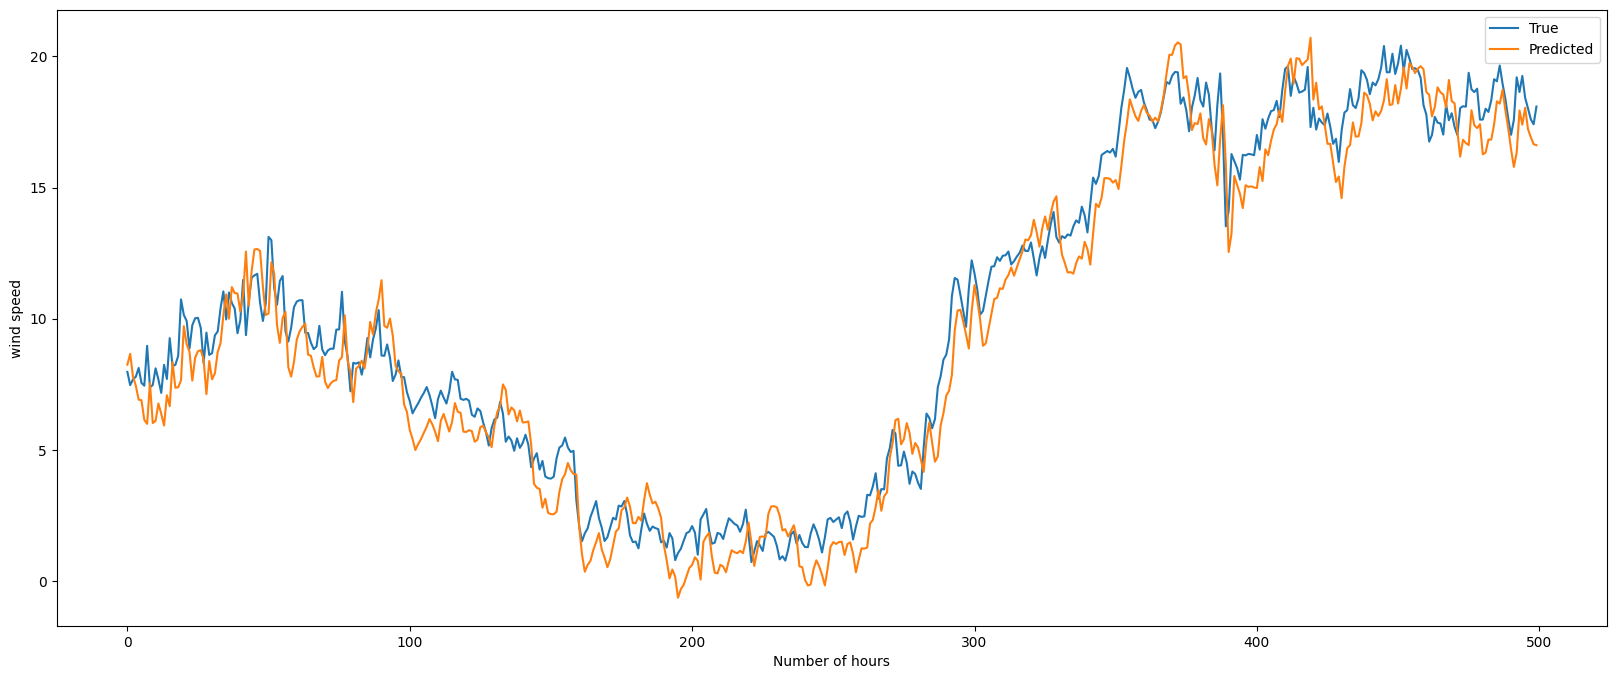

In [26]:
# line plot of observed vs predicted
fig = plt.figure(figsize=(20,8))
plt.plot(expectations[500:1000], label="True")
plt.plot(predictions[500:1000], label="Predicted")
plt.legend(loc='upper right')
plt.xlabel("Number of hours")
plt.ylabel("wind speed")
plt.show()

In [27]:
import pickle 

In [28]:
Pkl_Filename = "Pickle_RL1_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(lstm_model, file)

In [29]:
with open(Pkl_Filename, 'rb') as file:  
    Pickled_LR1_Model = pickle.load(file)

Pickled_LR_Model

NameError: name 'Pickled_LR_Model' is not defined

In [ ]:
score = Pickled_LR_Model.score(train, test)  
# Print the Score
print("Test score: {0:.2f} %".format(100 * score))  

# Predict the Labels using the reloaded Model
Ypredict = Pickled_LR_Model.predict(test)  

Ypredict